# Plot

In [ ]:
!pip install plotnine pandas scikit-misc -q

In [ ]:
import pandas as pd,os
import plotnine as p9
import warnings
warnings.filterwarnings('ignore')
p9.options.figure_size=(11,8)
from datetime import datetime
now=datetime.now()
date=f'{now.year}-{now.month:02d}-{now.day:02d}'

In [ ]:
fns=sorted([
    x for x in os.listdir('../synthesis/')
    if x.endswith('.csv') and '.synthesized.' in x and x.count('.')==4
])
fn=fns[-1]
fn

## Load data

In [ ]:
# df_all = pd.read_csv('../synthesis/data.jobcensus.synthesized.2021-01-12.csv')
# df_all = pd.read_csv('../synthesis/data.jobcensus.synthesized.2021-05-05.csv')
df_all = pd.read_csv('../synthesis/'+fn)
df_all

In [ ]:
df_alias = pd.read_csv('../synthesis/data.jobcensus.field_aliases.csv')
def rename_alias(x):
    if x.startswith('British: '): x=x[len('British: '):] +' (Br.)'
    if x.startswith('American: '): x=x[len('American: '):] +' (Am.)'
    return x
df_alias.FieldAlias=df_alias.FieldAlias.apply(rename_alias)
df_alias

In [ ]:
df=df_all.merge(df_alias,on='JobField',how='inner')
# df[df.JobField=='Ethnic Studies']

In [ ]:
df['JobYear']=df['JobYear'].apply(int)
# df

In [ ]:
# filter
dfm = df
dfm = dfm[dfm.FieldAlias!='--']
dfm.shape

## Plot 0: All jobs

In [ ]:
df_count0 = dfm[dfm.JobType!='Postdoc'].groupby(['JobYear']).count().reset_index()
df_count0

In [ ]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count'),df_count0) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle(f'Number of academic jobs (excl. postdocs), 2011-2020 (as of {date})')
)
fig.save(f'figures/fig0.num_jobs.{date}.png',dpi=300)
fig

## Plot 1: By job type

In [ ]:
df_count = dfm.groupby(['JobType','JobYear']).count().reset_index()
# df_count

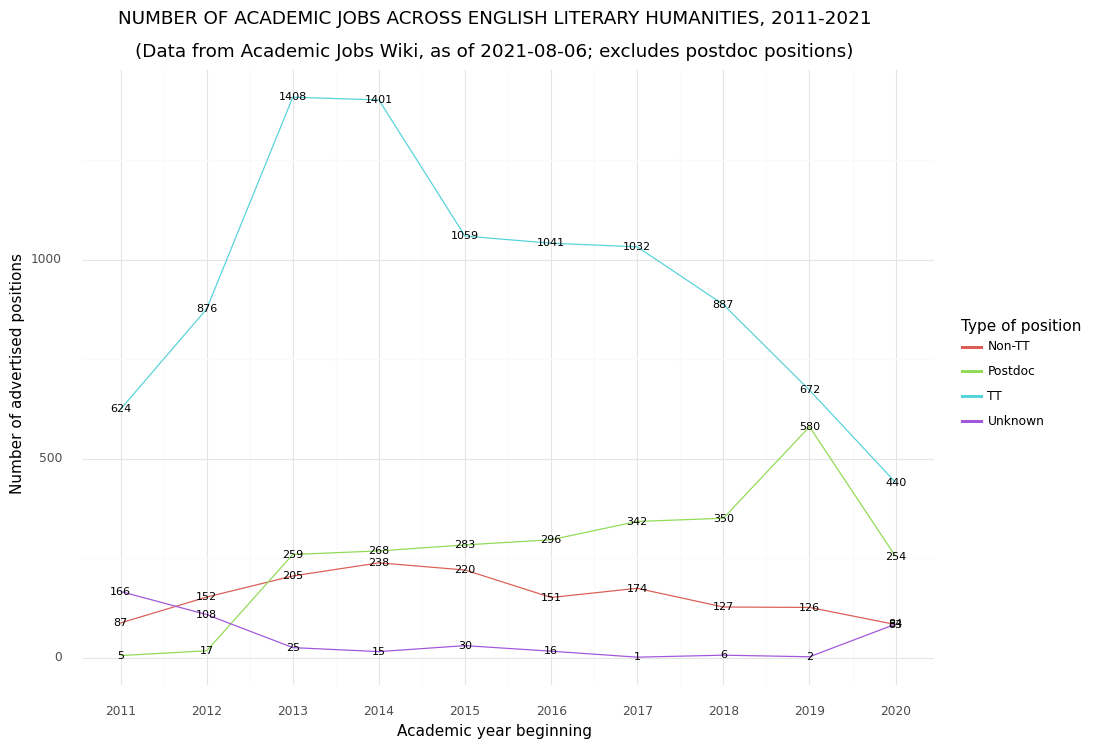

<ggplot: (8743308664513)>

In [211]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='JobType'),df_count) 
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'),size=8,color='black')
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.labs(
        title=f'NUMBER OF ACADEMIC JOBS ACROSS ENGLISH LITERARY HUMANITIES, 2011-2021\n\n(Data from Academic Jobs Wiki, as of {date}; excludes postdoc positions)',
        color='Type of position',
        x='Academic year beginning',
        y='Number of advertised positions'
    )
    + p9.theme_minimal()
)
fig.save(f'figures/fig1.num_jobs_per_type.{date}.png',dpi=300)
fig

## Plot 2: By field (top 10)

In [ ]:
# dict(dfm[dfm.JobField=='Ethnic Studies'].iloc[1])

In [ ]:
df_count2 = dfm.groupby(['JobYear','FieldAlias']).count().reset_index()
df_count2

In [ ]:
top5 = dfm[dfm.JobType!='Postdoc'].FieldAlias.value_counts().iloc[:5].index
top10 = dfm[dfm.JobType!='Postdoc'].FieldAlias.value_counts().iloc[:10].index
top10

In [ ]:
df_top10 = df_count2[df_count2.FieldAlias.isin(top10)]
df_top5 = df_count2[df_count2.FieldAlias.isin(top5)]
df_top10

In [ ]:
# fig=(
#     p9.ggplot(p9.aes(x='JobYear',y='Count',color='FieldAlias'), df_top10)
#     + p9.geom_line()
#     + p9.geom_text(p9.aes(label='Count'), size=10)
#     + p9.scale_x_continuous(breaks=range(2011,2021))
#     + p9.ggtitle(f'Number of academic jobs per field (excl. postdocs), showing top 10 fields (as of {date})')
# )
# fig.save(f'figures/fig2.num_jobs_per_field_top10.{date}.png',dpi=300)
# fig

In [ ]:
fig=(
    p9.ggplot(p9.aes(x='JobYear',y='Count',color='FieldAlias'), df_top5)
    + p9.geom_line()
    + p9.geom_text(p9.aes(label='Count'), size=10)
    + p9.scale_x_continuous(breaks=range(2011,2021))
    + p9.ggtitle(f'Number of academic jobs per field (excl. postdocs), showing top 5 fields (as of {date})')
    + p9.theme_minimal()
)
fig.save(f'figures/fig2.num_jobs_per_field_top5.{date}.png',dpi=300)
fig

## Plot 3: By field (all)

In [ ]:
df_count3=dfm[dfm.JobType!='Postdoc'].groupby(['JobYear','FieldAlias']).count().reset_index()
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Unknown')]

# not consistently tracked by wiki:
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Languages')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Communication/Media Studies')] # not tracked by wiki data
df_count3=df_count3[~df_count3.FieldAlias.str.contains('Poetry')] # not tracked by wiki data

In [160]:
# add zeros
unique_years = set(df_count3.JobYear)
missing_ld=[]
for field,fielddf in df_count3.groupby('FieldAlias'):
    field_years = set(fielddf.JobYear)
    for year in unique_years - field_years:
        dx=dict(fielddf.iloc[0])
        dx['JobYear']=year
        for k,v in dx.items():
            if not k in {'JobYear','FieldAlias'}:# and type(v)==int:
                dx[k]=0
        missing_ld.append(dx)
df_missing=pd.DataFrame(missing_ld)
df_count3=df_count3.append(df_missing)
overall_ranks=df_count3.groupby('FieldAlias').sum().Count.rank(ascending=False).sort_values()

## Stats?
from scipy.stats import linregress
o=[]
for fa,fadf in df_count3.query('Count!=0').groupby('FieldAlias'):
    y=fadf['Count']
    X=list(range(len(y)))
    d={'FieldAlias':fa}
    d['slope'], d['intercept'], d['r'], d['p'], d['std_err'] = linregress(X,y)
    d['r^2']=d['r']**2
    d['len']=len(y)
    d['sum']=y.sum()
    o+=[d]
statdf=pd.DataFrame(o)
statdf.sort_values('slope')

df_count3=df_count3.merge(statdf,on='FieldAlias')
df_count3['FieldAlias']=pd.Categorical(df_count3['FieldAlias'], categories=overall_ranks.index)
df_count3_nopostdoc = df_count3[df_count3.FieldAlias!='Postdoc']

In [161]:
# df_count3_nopostdoc

In [ ]:
figdf=df_count3_nopostdoc.query('Count!=0')#.sort_values(['sum','FieldAlias'],ascending=[0,1])
#figdf['FieldAlias']
#display(figdf)

fig=(
    p9.ggplot(
        p9.aes(x='JobYear',y='Count'),
        figdf
    )
    + p9.geom_smooth(
        p9.aes(
            color='slope',
            fill='slope'),
        alpha=.4,
        se=True,size=0,method='lm'
    )
    + p9.geom_line(size=.666, alpha=.25)
    + p9.geom_text(p9.aes(label='Count'),size=7,angle=45)
    
    + p9.facet_wrap('FieldAlias',scales='free_y')
    
    + p9.ggtitle(f'NUMBER OF ACADEMIC JOBS ACROSS ENGLISH LITERARY HUMANITIES, 2011-2021\n\n(Data from Academic Jobs Wiki, as of {date}; excludes postdoc positions)')
    + p9.theme_void()
    + p9.scale_x_continuous(breaks=[2010,2012,2014,2016,2018,2020])
    + p9.theme(
        panel_spacing_x=.1,
        panel_spacing_y=.2,
        axis_text_x=p9.element_text(color='black',alpha=1,size=6),
        #axis_title=p9.element_text(color='black',alpha=1,size=7),
        panel_grid_major_x=p9.element_line(color='silver',alpha=.5),
        #axis_title_y=p9.element_text(angle=90)
    )
    + p9.scale_color_distiller(type='div',palette='RdYlBu',direction=1)
    + p9.scale_fill_distiller(type='div',palette='RdYlBu',direction=1)
    + p9.labs(
        color='+/- Jobs per year',
        fill='+/- Jobs per year',
        x='Academic year beginning',
        y='Number of advertised positions'
    )
)
fig.save(f'figures/fig3.num_jobs_per_field_all.{date}.rescaled.v3.png',dpi=300)
fig

## Explore issues

### Unknown job types?

In [ ]:
df_unknown = dfm[(dfm.JobType=='Unknown')]
df_unknown.to_csv('../synthesis/data.unknown_jobtypes.csv',index=False)
df_unknown